# **Importing Necessary Library**


In [1]:
import torch
import os, glob
import pickle
import time
import numpy as np
import torch.nn.functional as F

from music21 import *
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

print("Pytorch Version:",torch.__version__)
print("GPU Avaiable:",torch.cuda.is_available())

device ='cuda' if torch.cuda.is_available() == True else 'cpu'
print("Setting device to:",device)


Pytorch Version: 1.9.0
GPU Avaiable: False
Setting device to: cpu


# **Importing Dataset**

In [2]:
path = 'dataset_pickle/pokemon.pickle'
with open(path,'rb') as file:
  inputs = pickle.load(file)
print(inputs.shape)
print(type(inputs))

(167285, 100)
<class 'numpy.ndarray'>


In [3]:
class MIDI():
    def __init__(self, seq_length):
        self.seq_length = seq_length
        self.file_notes = []
        self.trainseq = []
        self.transfer_dic = dict()
        self.dic_n = 0

    def parser(self, folderName):
        """ Get all the rests and notes and chords from the midi files """

        for file in glob.glob(f"{folderName}/*.mid"):
            midi = converter.parse(file)
            print("Parsing %s" % file)

            notes = []
            for element in midi.flat.elements:
                print(elements)
                if isinstance(element, note.Rest) and element.offset != 0:
                    notes.append('R')
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                if isinstance(element, chord.Chord):
                    notes.append('.'.join(str(pitch) for pitch in element.pitches))

            self.file_notes.append(notes)
        note_set = sorted(set(note for notes in self.file_notes for note in notes))
        self.dic_n = len(note_set)
        # A dictionary to map notes, chords and rest to integers
        self.transfer_dic = dict((note, number) for number, note in enumerate(note_set))

    def prepare_sequences(self):
        """ Prepare the sequences used by the Neural Network """

        # create input sequences and the corresponding outputs
        for notes in self.file_notes:
            for i in range(len(notes) - self.seq_length):
                self.trainseq.append([self.transfer_dic[note] for note in notes[i:i + self.seq_length]])

        # Normalize sequences between -1 and 1
        self.trainseq = np.array(self.trainseq)
        self.trainseq = (self.trainseq - float(self.dic_n) / 2) / (float(self.dic_n) / 2)

        return self.trainseq

    def create_midi(self, prediction_output, filename):
        """ convert the output from the prediction to notes and create a midi file
        from the notes """
        offset = 0
        midi_stream = stream.Stream()

        # create note and chord objects based on the values generated by the model
        for pattern in prediction_output:
            # rest
            if pattern == 'R':
                midi_stream.append(note.Rest())
            # chord
            elif ('.' in pattern) or pattern.isdigit():
                notes_in_chord = pattern.split('.')
                notes = []
                for current_note in notes_in_chord:
                    new_note = note.Note(current_note)
                    new_note.storedInstrument = instrument.Piano()
                    notes.append(new_note)
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                midi_stream.append(new_chord)
            # note
            else:
                new_note = note.Note(pattern)
                new_note.offset = offset
                new_note.storedInstrument = instrument.Piano()
                midi_stream.append(new_note)

            # increase offset each iteration so that notes do not stack
            offset += 0.5

        # midi_stream.show('text')
        midi_stream.write('midi', fp=f'{filename}.mid')

In [4]:
# midi = MIDI(seq_length=100)
# notes = midi.parser('/content/drive/MyDrive/Major Project/GAN_Dataset')
# sequences = midi.prepare_sequences()

In [5]:
# sequences = torch.Tensor(sequences).unsqueeze(1)

In [7]:
# Hyperparameters
vocab_size = 100
input_size = vocab_size
num_feats = vocab_size
hidden_size = 256
num_layers = 2 #2 layer stack is enough to detect complex features

sequence_length = 1
lr = 2e-1
batch_size = 16   #larger batch size converges fast takes large gradient step
epochs = 7

In [8]:
class Music_Dataset(Dataset):
  def __init__(self, music):
    self.music = music
    #self.label = label
#     print("init")
    self.n_samples = music.shape[0]
    

  def __getitem__(self, index):
#     print("getitem")
    return self.music[index]

  def __len__(self):
#     print("len")
    return self.n_samples

input = torch.from_numpy(inputs).unsqueeze(dim=1)
# inputs = torch.tensor(inputs).unsqueeze(1)
print(type(input))
Data = Music_Dataset(input)


<class 'torch.Tensor'>


In [9]:
train_loader = DataLoader(Data, batch_size = batch_size, shuffle = True, drop_last = True)

for i in train_loader:
  print(i.shape)
  #print(i.shape,j.unsqueeze(1).shape,type(i), type(j))
  #print(find_index(i[1]))
  break

torch.Size([16, 1, 100])


# **Discriminator Network** #


In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()


    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_size * sequence_length*2, 1)
    self.sigmoid = nn.Sigmoid()

    #create optimizer, using stochastic gradient descent
    self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)

    #counter and accumulator for progress
    self.counter = 0
    self.progress = []
    self.batch_size = batch_size

  def forward(self,x):
    # since it is bi directional
    h0 = torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size).to(device)
    # Forward propagate LSTM
    out, _ = self.lstm(
        x, (h0,c0)
    )  # out: tensor of shape (batch_size, seq_length, hidden_size)
    out = out.reshape(out.shape[0], -1)

    # Decode the hidden state of the last time step
    out = self.fc(out)

    return self.sigmoid(out)

  def init_hidden(self):
    # Set initial hidden and cell states
    h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)

    return (h0,c0)
  
  def discriminator_loss(self, outputs, targets):
    return F.binary_cross_entropy_with_logits(outputs, targets)

  def train(self, inputs, targets):
    #calculate the output of the network 
    outputs = self.forward(inputs)
    
    #calculate the loss 
    loss = self.discriminator_loss(outputs, targets)

    #increase the counter of training and accumulate the error in every 10 count
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      
    # zero gradients, perform a backward pass, update weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    

    # print('training from discriminator')
    # Finally, we can add a function plot_progress() to draw a chart of the losses accumulated during training
  def plot_progress(self):

    plt.figure(figsize=(16,8))
    plt.plot(self.progress,label="D-Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title('Loss Vs Iterations');
    plt.show()
    


In [11]:
print(Discriminator)

<class '__main__.Discriminator'>


# **Generator Network** #

In [12]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()


    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.fc1 = nn.Linear(in_features=(num_feats*2), out_features=hidden_size)
    self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size ,num_layers=num_layers, 
                        batch_first=True)
    self.fc2 = nn.Linear(in_features=hidden_size, out_features=num_feats)
    self.dropout = nn.Dropout(p=0.6)
    self.tanh = nn.Tanh()
    #create optimizer, using stochastic gradient descent
    self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    #counter and accumulator for progress
    self.counter = 0
    self.progress = []
    self.batch_size = batch_size

  def forward(self, x):
    # print(x.shape)
    # Set initial hidden and cell states
    h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
    #print(f'after h0:{h0.shape}')
    # x: (batch_size, seq_len, num_feats)
    
    #batch_size, seq_len, num_feats = x.shape

    # split to seq_len * (batch_size * num_feats)
    x = torch.split(x, 1, dim=1)
    #print(len(x),x[0].shape)
    x = [x_step.squeeze(dim=1) for x_step in x]
    #print(len(x))
    # create dummy-previous-output for first timestep
    prev_gen = torch.empty([batch_size, num_feats]).uniform_().to(device)
    #print(prev_gen.shape)
    # manually process each timestep
    gen_feats = []
    for x_step in x:
        # concatenate current input features and previous timestep output features
        #print(x_step)
        concat_in = torch.cat((x_step, prev_gen), dim=-1)
        out1 = F.leaky_relu(self.fc1(concat_in))
        #print(out1.shape)
        out1 = out1.unsqueeze(1)
        #print('before lstm')
        #print(out1.shape)

        out2, hidden = self.lstm( out1, (h0,c0))
        #print('after lstm')
        out2 = self.dropout(out2) # feature dropout only (no recurrent dropout)
        #print('before fc2')
        out3 = self.fc2(out2)
        #print('after fc2')
        # prev_gen = F.relu(self.fc_layer2(h2)) #DEBUG
        gen_feats.append(out3)
        #print('after last')
        
    # seq_len * (batch_size * num_feats) -> (batch_size * seq_len * num_feats)
    gen_feats = torch.stack(gen_feats, dim=1).squeeze(1)
    #gen_feats = torch.stack(gen_feats, dim=1)
    #print(gen_feats.shape)
    final_output = self.tanh(gen_feats)
    return gen_feats

  def init_hidden(self, batch_size):
      # Set initial hidden and cell states
    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

    return (h0,c0)

  def train(self, D, inputs, targets):
    #print('before training G')
    # calculate the output of the network
    g_output = self.forward(inputs)
    # print('from g train')
    # print(g_output.shape)
    # pass onto Discriminator
    d_output = D.forward(g_output)

    # calculate error
    loss = D.discriminator_loss(d_output, targets)
    # increase counter and accumulate error every 10
    self.counter += 1
    if (self.counter % 5 == 0):
      self.progress.append(loss.item())
    #print('training from generator')

    # zero gradients, perform a backward pass, update weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

   #print('After Training G')    

# **GAN** #

In [13]:
class GAN:
  def __init__(self):
    self.D = Discriminator().to(device)
    self.G = Generator().to(device)
    self.image_list = []
  
  # creating a function to generate random noise
  def random_noise(self):
    min = -1
    max = 1
    # torch.rand(batch_size,1 ,vocab_size)
    inputs = (max-min)*torch.rand((batch_size,1,vocab_size)) + min
    return inputs.to(device).float()
  
  def train(self):
    
    # Training Generator and Discriminator

    ones = torch.ones(batch_size, 1).to(device)
    zeros = torch.zeros(batch_size, 1).to(device)


    Dataset = DataLoader(Data, batch_size = batch_size, shuffle = True, drop_last = True)
    start = time.time()
    for i in range(epochs):
      for music in tqdm(Dataset,desc = f'Epoch({i + 1}/{epochs}'):
        # print(music.shape)
        # print(zeros.shape)
        # print(ones.shape)
        #Training Discriminator in True
        #target = target.unsqueeze(1).to(device).float()
        self.D.train( music.to(device).float(), ones)
        
        
        ##Training Discriminator in False
        #use detach() so gradients in G are not calculated
        self.D.train( self.G.forward(self.random_noise()), zeros)
        
        #Training Generator
        self.G.train(self.D, self.random_noise(), ones)
        
        #Storing the Generator ouput loop for visualizing in image_list in every 1000 training cycles
        if (i%100 == 0):
          output = self.G.forward(self.random_noise())
          self.image_list.append(output.cpu().detach().numpy())
    end = time.time()
    #print(f'\nExecution Time:{end-start}')

  def visualize_losses(self):
    plt.figure(figsize=(10,5))
    plt.plot(self.D.progress,label="D-Loss")
    plt.plot(self.G.progress,label="G-loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title('Loss Vs Iterations');
    plt.savefig(f'./model/{lr}lr_{epochs}E_{batch_size}BS-pokemon.png',bbox_inches ="tight",pad_inches = 1)
    plt.show()
    
    

  # def visualize_results(self,images_list, size = 6, shape = (4, 4)):
  #   fig = plt.figure(figsize = (size, size))
  #   grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.04)
  #   for ax, image in zip(grid, images_list):
  #     ax.imshow(image[0],cmap='gray')
  #     # ax.axis('off')

  # def generate(self,random_value):
  #   image_list = self.G.forward(random_value)
  #   self.visualize_results(image_list.cpu().detach().numpy())

# **Running**

In [14]:
model = GAN()
model.train()

Epoch(1/7:   0%|          | 0/10455 [00:00<?, ?it/s]

Epoch(2/7:   0%|          | 0/10455 [00:00<?, ?it/s]

Epoch(3/7:   0%|          | 0/10455 [00:00<?, ?it/s]

Epoch(4/7:   0%|          | 0/10455 [00:00<?, ?it/s]

Epoch(5/7:   0%|          | 0/10455 [00:00<?, ?it/s]

Epoch(6/7:   0%|          | 0/10455 [00:00<?, ?it/s]

Epoch(7/7:   0%|          | 0/10455 [00:00<?, ?it/s]

In [15]:
PATH = f'./model/{lr}lr_{epochs}E_{batch_size}BS_pokemon.pth'
torch.save(model.G.state_dict(), PATH)

In [16]:
model2 = GAN()
model2.G.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
g = Generator().to(device)
g.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
noise = model.random_noise()

In [19]:
output1 =g(noise)

In [20]:
output = model2.G(noise)


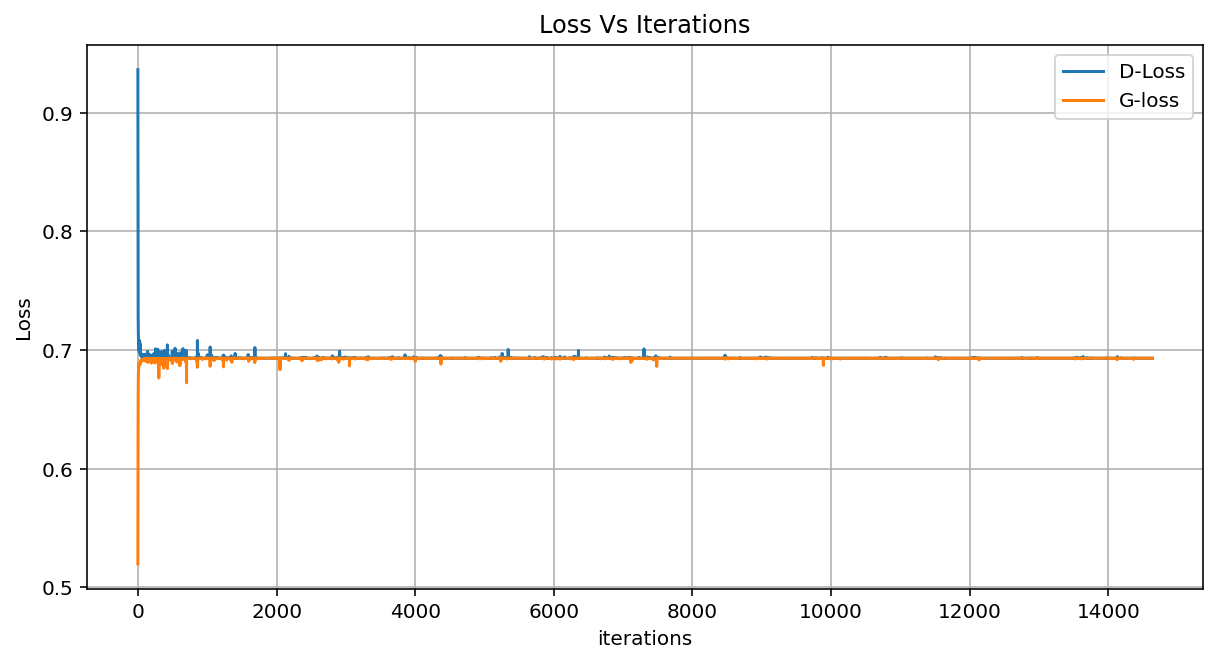

In [21]:
model.visualize_losses()
